### Katarzyna Główczyk

In [1]:
from pyspark.sql import DataFrame
from graphframes import graphframe
from pyspark.shell import spark

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.5.0
      /_/

Using Python version 3.11.6 (main, Oct  3 2023 10:40:35)
Spark context Web UI available at http://be74838d2d01:4040
Spark context available as 'sc' (master = local[*], app id = local-1732835687936).
SparkSession available as 'spark'.


### 1
Wczytać graf Facebooka, krawędzie z pliku musae_facebook_edges.csv, atrybuty page_name oraz page_type z pliku musae_facebook_target.csv.  Policzyć liczbę krawędzi i wierzchołków. (1 p.)

In [2]:
from pyspark.sql import SparkSession
from graphframes import GraphFrame

spark = SparkSession.builder.appName("FacebookGraph").getOrCreate()

In [3]:
attributes = spark.read.csv("facebook_large/musae_facebook_target.csv", header=True, inferSchema=True).select("id", "page_name", "page_type")
attributes

DataFrame[id: int, page_name: string, page_type: string]

In [4]:
edges = spark.read.csv("facebook_large/musae_facebook_edges.csv", header=True, inferSchema=True)
edges = edges.withColumnRenamed("id_1", "src").withColumnRenamed("id_2", "dst")
edges

DataFrame[src: int, dst: int]

In [5]:
g = GraphFrame(attributes, edges)

In [6]:
num_vertices = g.vertices.count()
num_edges = g.edges.count()

print(f"Number of vertices: {num_vertices}")
print(f"Number of edges: {num_edges}")

Number of vertices: 22470
Number of edges: 171002


### 2
Sprawdzić czy graf jest spójny. Czy dwa podgrafy utworzone dla typów strony governmental organizations oraz television shows też są spójne? (1 p.)

In [7]:
spark.sparkContext.setCheckpointDir("/tmp/graphframes-example-connected-components")

In [8]:
def is_graph_consistent(graph):
    connected_components = graph.connectedComponents()
    cc=connected_components.select("component").distinct().count()
    return cc == 1, cc

In [9]:
is_graph_consistent(g)

(True, 1)

In [10]:
def is_subgraph_consistent(graph, page_type):
    subgraph = graph.filterVertices(f"page_type = '{page_type}'")
    return is_graph_consistent(subgraph)

In [11]:
is_subgraph_consistent(g, "government")

(False, 57)

In [12]:
is_subgraph_consistent(g, "tvshow")

(False, 71)

Cały graf jest spójny, co oznacza, że istnieje ścieżka pomiędzy dowolnymi dwoma wierzchołkami (True, 1). Natomiast podgraf utworzony dla stron typu governmental organizations składa się z 57 spójnych składowych, a podgraf dla television shows z 71 spójnych składowych, co oznacza, że oba te podgrafy nie są spójne.

### 3
Spośród 1000 stron o najwyższym PageRank znaleźć 50 takich (wypisać page_name i page_type), które mają najmniej połączeń oraz 50 o największej liczbie połączeń. Który typ strony był dominujący w każdej z tych kategorii? Narysować wykres zależności PageRank od liczby krawędzi dla wierzchołków (scatter plot) (2 p.)

In [13]:
import pyspark.sql.functions as F

In [14]:
degrees = (
    edges.groupBy("src").agg(F.count("*").alias("degree"))
)
degrees.select('src','degree').show(truncate=False)

+-----+------+
|src  |degree|
+-----+------+
|148  |10    |
|463  |8     |
|471  |1     |
|496  |237   |
|18800|11    |
|833  |35    |
|5300 |16    |
|1088 |3     |
|1238 |1     |
|1342 |16    |
|1580 |1     |
|1591 |5     |
|1645 |3     |
|1829 |12    |
|2122 |1     |
|2142 |13    |
|4101 |2     |
|2366 |10    |
|2659 |4     |
|2866 |1     |
+-----+------+
only showing top 20 rows



In [15]:
attributes_with_degree = (
    attributes.join(degrees, attributes["id"] == degrees["src"], "left_outer")
)

In [16]:
from pyspark.sql.functions import coalesce

attributes_with_degree = attributes_with_degree.withColumn("src", coalesce(attributes_with_degree["src"], attributes_with_degree["id"]))
attributes_with_degree = attributes_with_degree.na.fill(0, subset=["degree"])

In [17]:
attributes_with_degree.select('*').show(truncate=False)

+---+--------------------------------------------+----------+---+------+
|id |page_name                                   |page_type |src|degree|
+---+--------------------------------------------+----------+---+------+
|0  |The Voice of China 中国好声音               |tvshow    |0  |1     |
|1  |U.S. Consulate General Mumbai               |government|1  |34    |
|2  |ESET                                        |company   |2  |12    |
|3  |Consulate General of Switzerland in Montreal|government|3  |10    |
|4  |Mark Bailey MP - Labor for Miller           |politician|4  |51    |
|5  |Victor Dominello MP                         |politician|5  |22    |
|6  |Jean-Claude Poissant                        |politician|6  |16    |
|7  |Deputado Ademir Camilo                      |politician|7  |3     |
|8  |T.C. Mezar-ı Şerif Başkonsolosluğu          |government|8  |3     |
|9  |Army ROTC Fighting Saints Battalion         |government|9  |2     |
|10 |NASA Student Launch                         |govern

In [18]:
g2 = GraphFrame(attributes_with_degree, edges)

In [19]:
results = g2.pageRank(resetProbability=0.15, tol=0.01)
display(results.vertices)

DataFrame[id: int, page_name: string, page_type: string, src: int, degree: bigint, pagerank: double]

In [20]:
top_1000_pagerank = results.vertices.orderBy("pagerank", ascending=False).limit(1000)

In [21]:
top_50_degree = top_1000_pagerank.orderBy(F.desc("degree")).limit(50)
top_50_degree.select('*').show(truncate=False)

+-----+----------------------------------------------------+----------+-----+------+------------------+
|id   |page_name                                           |page_type |src  |degree|pagerank          |
+-----+----------------------------------------------------+----------+-----+------+------------------+
|14497|U.S. Army Chaplain Corps                            |government|14497|220   |16.067926524867406|
|11003|Barack Obama                                        |politician|11003|180   |8.284463388548275 |
|11332|NASA - National Aeronautics and Space Administration|company   |11332|177   |3.474377784934516 |
|16895|U.S. Army                                           |government|16895|158   |20.389454189549   |
|21120|European Parliament                                 |government|21120|146   |10.028994274018666|
|13294|European Commission                                 |government|13294|129   |6.010924840327058 |
|14650|Manfred Weber                                       |poli

In [22]:
dominant_type_top = top_50_degree.groupBy("page_type").agg(F.count("*").alias("count")).orderBy(F.desc("count")).limit(1)
dominant_type_top.show()

+----------+-----+
| page_type|count|
+----------+-----+
|government|   37|
+----------+-----+



In [23]:
low_50_degree = top_1000_pagerank.orderBy(F.asc("degree")).filter("degree >= 0").limit(50)
low_50_degree.select('*').show(truncate=False)

+-----+------------------------------------------+----------+-----+------+------------------+
|id   |page_name                                 |page_type |src  |degree|pagerank          |
+-----+------------------------------------------+----------+-----+------+------------------+
|22207|Digicel                                   |company   |22207|0     |17.45798688821351 |
|22380|王定宇                                    |politician|22380|0     |12.199358938764433|
|21758|Archivo General                           |government|21758|0     |17.01526421194011 |
|22208|U.S. Department of State: Consular Affairs|government|22208|0     |66.3374736440113  |
|21681|Son of Zorn                               |tvshow    |21681|0     |16.63478878408979 |
|22440|City of Los Altos Police Department       |government|22440|0     |54.630144664599754|
|22317|Dalila Nesci                              |politician|22317|0     |15.886122521624204|
|22438|Federica Mogherini                        |politician|22

In [24]:
dominant_type_low = low_50_degree.groupBy("page_type").agg(F.count("*").alias("count")).orderBy(F.desc("count")).limit(1)
dominant_type_low.show()

+----------+-----+
| page_type|count|
+----------+-----+
|government|   24|
+----------+-----+



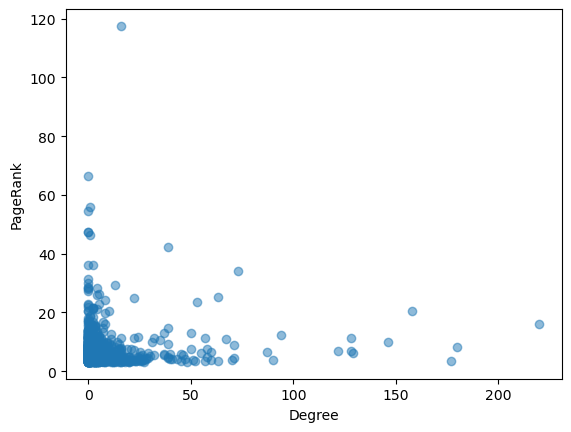

In [25]:
import matplotlib.pyplot as plt

x = top_1000_pagerank.select("degree").collect()
y = top_1000_pagerank.select("pagerank").collect()

plt.scatter(x, y, alpha=0.5)
plt.xlabel('Degree')
plt.ylabel('PageRank')
plt.show()

Strony typu government są dominujące w analizowanym grafie, zarówno wśród najbardziej, jak i najmniej połączonych wierzchołków. Wykres sugeruje, że PageRank nie zawsze jest proporcjonalny do degree i zależy od struktury połączeń oraz ich jakości (kontekstu w grafie).

### 4
Korzystając z Pregel API zaimplementować następujący algorytm. W pierwszym kroku wybrana strona publikuje post fake news. W kolejnym kroku ten post publikowany jest przez 1/4 losowo wybranych kontaktów tej strony. W dalszych krokach, dla każdej strony, która opublikowała już ten post, losowo wybrane 1/4 jej kontaktów publikuje go u siebie. Pokazać jak zmienia się liczba stron które opublikowały post w zależności od liczby kroków. (2 p.)
Opcjonalnie: Sprawdzić powyższą zależność dla współczynnika innego niż 1/4.

In [26]:
spark.sparkContext.setCheckpointDir('checkpoints3')

print("Attributes:")
attributes.show(5)
print("Edges:")
edges.show(5)

Attributes:
+---+--------------------+----------+
| id|           page_name| page_type|
+---+--------------------+----------+
|  0|The Voice of Chin...|    tvshow|
|  1|U.S. Consulate Ge...|government|
|  2|                ESET|   company|
|  3|Consulate General...|government|
|  4|Mark Bailey MP - ...|politician|
+---+--------------------+----------+
only showing top 5 rows

Edges:
+---+-----+
|src|  dst|
+---+-----+
|  0|18427|
|  1|21708|
|  1|22208|
|  1|22171|
|  1| 6829|
+---+-----+
only showing top 5 rows



100%|██████████| 14/14 [12:40<00:00, 54.35s/it] 


<Axes: >

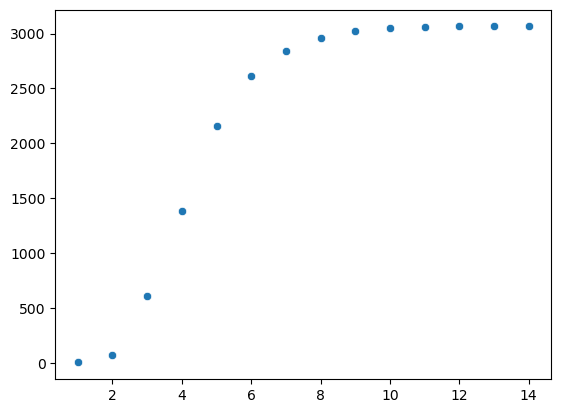

In [36]:
from pyspark.sql.types import IntegerType
from graphframes.lib import Pregel
import random
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Filtruje dane, aby sprawdzić, czy wierzchołek o ID 12756 istnieje
# W tym przypadku zakładamy, że jest to strona, która publikuje pierwszy post
attributes.filter(F.col('id') == '12756').collect()

spark.sparkContext.setCheckpointDir('checkpoints3')

P = 1/4

# Funkcja określająca, czy wierzchołek repostuje fake news
# Wylicza prawdopodobieństwo repostu w zależności od liczby otrzymanych postów.
# - prob: 1 - (1 - P)^seen_posts -> prawdopodobieństwo przynajmniej jednego sukcesu.
# - random.random(): generuje liczbę losową z zakresu [0, 1].
# Zwraca True, jeśli post zostanie opublikowany, False w przeciwnym przypadku.
def reposted(seen_posts: int) -> bool:
    prob = 1 - (1 - P) ** seen_posts
    return random.random() < prob

# Rejestracja funkcji jako UDF (User-Defined Function), aby można było jej używać w Spark
reposted_udf = F.udf(reposted, 'boolean')

# Symulacja procesu rozprzestrzeniania fake news przy użyciu Pregel API
sim = g.pregel \
    .setMaxIter(10) \
    .withVertexColumn('posted',
                      F.when(F.col('id') == '12756', True).otherwise(False),
                      F.coalesce(Pregel.msg() | F.col('posted'), F.col('posted'))) \
    .sendMsgToSrc(Pregel.dst('posted')) \
    .aggMsgs(
        reposted(
            F.sum(
                Pregel.msg().cast('int')
            )
        )
    ) \
    .run()

# Lista przechowująca liczbę wierzchołków, które opublikowały post w każdej iteracji
posted = []
iters = list(range(1, 15))
# Iteracyjna analiza liczby publikujących wierzchołków
for it in tqdm(iters):
    count = 1 # Liczba wierzchołków publikujących
    while count <= 1: # Gwarancja, że przynajmniej jeden wierzchołek publikuje (dla stabilności symulacji)
        sim = g.pregel \
            .setMaxIter(it) \
            .withVertexColumn('posted',
                              F.when(F.col('id') == '12756', True).otherwise(False),
                              F.coalesce(Pregel.msg() | F.col('posted'), F.col('posted'))) \
            .sendMsgToSrc(Pregel.dst('posted')) \
            .aggMsgs(
                reposted(
                    F.sum(
                        Pregel.msg().cast('int')
                    )
                )
            ) \
            .run()

        count = sim.filter(F.col('posted') == True).count()
    posted.append(count)

sns.scatterplot(x=iters, y=posted)

### 5
Narysować wykres rozkładu stopnia wierzchołków w grafie w skali logarytmicznej. Można skorzystać z metody stat.approxQuantile. Czy sieć jest bezskalowa (scale-free)? https://barabasi.com/f/623.pdf  (2 p.)

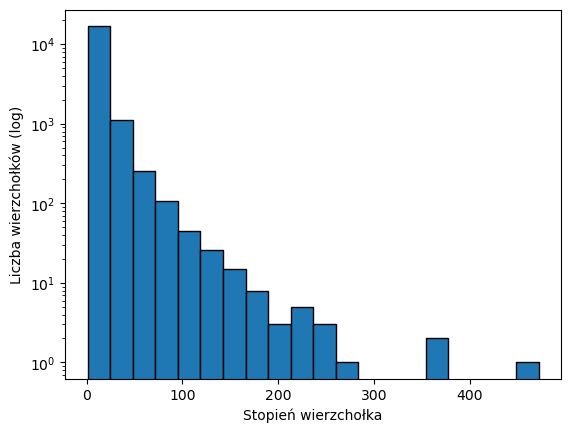

In [37]:
import numpy as np

degrees_data = degrees.select("degree").collect()
degrees_values = [row["degree"] for row in degrees_data]

plt.hist(degrees_values, bins=20, log=True, edgecolor="black")
plt.xlabel('Stopień wierzchołka')
plt.ylabel('Liczba wierzchołków (log)')
plt.show()

Histogram pokazuje, że większość wierzchołków ma niski stopień (połączenia), co jest typowe dla sieci bezskalowych.